In [15]:
import os, glob
import numpy as np

from yellowbrick.target import FeatureCorrelation
from yellowbrick.features import Rank2D
from yellowbrick.features.pca import PCADecomposition

from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

import h5py
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from GNN.utils.datautils import (
    get_data,
    balance_dataset,
    find_transition_regions
)

In [2]:
label = "dark_or_light"
sampling = "downsample"

# 1. Load combined features from SubFind & Sownak 

In [3]:
# arxiv:1905.08799 talks about this stellar mass cut on page 4 top right column
output_file = 'merged_dataframe.h5'                                          
data_path = '/cosma6/data/dp004/dc-cues1/tng_dataframes/'

train, test = get_data(data_path + output_file, label)
print(len(train.columns.values))

20


In [4]:
train.sample(n=3, random_state=1)

,M200_DMO,M200c,Rmax,R200c,Cnfw,Rhosnfw,Formation Time,Nmergers,MassPeak,vpeak,N_subhalos,VelDisp,Vmax,Spin,fsub_unbound,x_offset,x_dmo,y_dmo,z_dmo,labels
33967,3.222000e+11,3.222035e+11,0.025756,111.500549,9.541781,1.095388e+07,1.151545,1.0,5.354194e+11,158.870071,1.0,73.738907,132.469254,13.077200,0.007121,657.466485,265.680687,269.871812,199.033187,True
87515,1.594000e+11,1.594472e+11,0.015614,88.186943,16.635263,4.515792e+07,1.966384,1.0,2.638693e+11,116.536285,2.0,62.604664,114.830658,5.033566,0.008136,2196.179003,144.617547,260.009687,162.087938,True
14264,4.474000e+11,4.473788e+11,0.058838,124.389297,4.836464,2.172080e+06,1.044931,2.0,7.858822e+11,138.228745,9.0,74.484482,128.212570,10.046845,0.170153,1174.137065,42.755012,50.261793,204.619156,True


In [5]:
## Balance training set in the transition region                             
center_transition, end_transition = find_transition_regions(train)
print(center_transition, end_transition)

157281436666.60678 1790293584137.6719


/cosma/home/dp004/dc-beck3/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


In [8]:
train = balance_dataset(                                                     
    train, center_transition, end_transition, sampling
)


In [9]:
train_features = train.drop(columns="labels")                                
train_labels = train["labels"]

test_features = test.drop(columns="labels")                                
test_labels = test["labels"]

feature_names = train_features.columns.values

In [10]:
## Standarize features                                                       
scaler = StandardScaler()
scaler.fit(train_features.values)
train_features_std = scaler.transform(train_features.values)
test_features_std = scaler.transform(test_features.values)

# 2 Feature Importance

## 2.0 PCA decomposition

In [16]:
def pca_transform(train: np.ndarray, test: np.ndarray):
    """
    """
    pca = PCA(svd_solver='full')

    pca_scores = []
    n_components = np.arange(0, train.shape[1], 1)

    # determine cross-val. score for different dimensions of feature space
    for n in n_components:
        pca.n_components = n
        pca_scores.append(np.mean(cross_val_score(pca, train, cv=5)))

    # choose # of dimensions with highest cross-val. score
    # another option would be: pca = PCA(svd_solver='full', n_components='mle')
    n_components_pca = n_components[np.argmax(pca_scores)]
    pca.n_components = n_components_pca
    
    # Perform feature optimization
    train = pca.fit_transform(train)
    test = pca.fit_transform(test)

    return train, test, n_components_pca

train_features_pca, test_features_pca, n_compontent = pca_transform(train_features_std, test_features_std)
print("Features %d <-> PCA's %d" % (train_features_std.shape[1], n_compontent))

Features 19 <-> PCA's 18


## 2.1 Pearson correlation score

### Before PCA

/cosma/home/dp004/dc-beck3/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


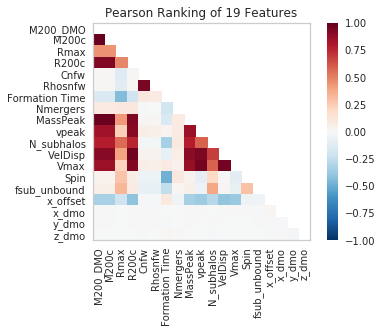

In [11]:
visualizer = Rank2D(features=feature_names, algorithm='pearson')

visualizer.fit(train_features_std, test_labels.values)
visualizer.transform(train_features_std)  
visualizer.poof()  

### After PCA

/cosma/home/dp004/dc-beck3/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


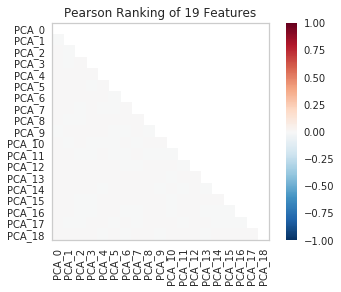

In [17]:
visualizer = Rank2D(features=['PCA_%d' % dd for dd in range(train_feat_pca.shape[1])], algorithm='pearson')

visualizer.fit(train_feat_pca, test_labels.values)
visualizer.transform(train_feat_pca)  
visualizer.poof()

## 2.2 PCA - Cumulative explained variance ratio

/cosma/home/dp004/dc-beck3/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


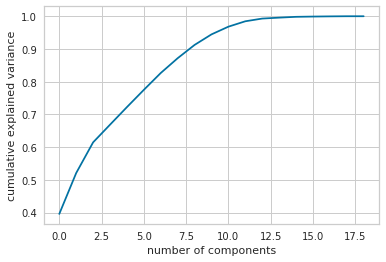

In [19]:
pca = PCA().fit(train_features_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

## 2.3 PCA - variance ratios in scaled dataset

In [ ]:
scaler = StandardScaler()

scaler_data = scaler.fit_transform(df_subf)
pca = PCA().fit(scaler_data)

# Plot
fig, ax1 = plt.subplots()

# Axis 1
ax1.semilogy(
    pca.explained_variance_ratio_,
    '--bo',
    label='explained variance ratio',
)
color =  ax1.lines[0].get_color()
for tl in ax1.get_yticklabels():
    tl.set_color('b')
ax1.set_xlabel('principal component')
plt.legend(loc=(0.01, 0.075))

# Axis 2
ax2 = ax1.twinx()
ax2.semilogy(
    pca.explained_variance_ratio_.cumsum(),
    '--go',
    label='cumulative explained variance ratio',
)
for tl in ax2.get_yticklabels():
    tl.set_color('g')

plt.legend(loc=(0.01, 0))

## 2.3 PCA - inverse & biases

In [ ]:
n_comp = 7
pca = PCA(n_components=n_comp)

data_scaled = StandardScaler().fit_transform(df_subf)


pca_data = pca.fit_transform(data_scaled)
pca_inv_data = pca.inverse_transform(np.eye(n_comp))

In [ ]:
# Inverse

sns.heatmap(
    #np.log(pca_inv_data),
    pca.inverse_transform(np.eye(n_comp)),
    cmap="hot",
    cbar=False,
)
plt.xlabel('original feature index')
plt.ylabel('principal component')

In [ ]:
# Biases

plt.plot(
    pca_inv_data.mean(axis=0), 
    '--o',
    label='mean',
)
plt.plot(
    np.square(pca_inv_data.std(axis=0)),
    '--o',
    label='variance',
)
plt.legend(loc='best')
plt.ylabel('feature contribution')
plt.xlabel('feature index')